# Auto Compression

- [Tutorial](https://github.com/hyperopt/hyperopt/wiki/FMin)

In [72]:
from hyperopt import hp
from hyperopt import fmin
import hyperopt
import math
import numpy as np
import argparse
import time
import datetime
import os
import sys
import torch
import torch.nn as nn
import torch.optim
from torch.autograd import Variable
# script_dir = os.path.dirname(__file__)
# module_path = os.path.abspath(os.path.join(script_dir, '..', '..'))
# try:
#     import distiller
# except ImportError:
#     sys.path.append(module_path)
#     import distiller
import distiller
import apputils
from models import ALL_MODEL_NAMES, create_model

import pandas as pd
import json
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [3]:
def float_range(val_str):
    val = float(val_str)
    if val < 0 or val >= 1:
        raise argparse.ArgumentTypeError('Must be >= 0 and < 1 (received {0})'.format(val_str))
    return val

# We only change the pruning hyperparameter for convolution layer, 
# and the value ranges from 0.01 to 0.99 
def get_space():
    space = {}
    for name, parameter in model.named_parameters():
        if 'conv' in name and 'weight' in name:
            space[name] = hp.uniform(name, 0.01, 0.99)
    return space

## Argument Settings

In [4]:
parser = argparse.ArgumentParser(description='Distiller image classification model compression')
parser.add_argument('data', metavar='DIR', help='path to dataset')
parser.add_argument('--arch', '-a', metavar='ARCH', default='resnet20_cifar',
                    choices=ALL_MODEL_NAMES,
                    help='model architecture: ' +
                    ' | '.join(ALL_MODEL_NAMES) +
                    ' (default: resnet20_cifar)')
parser.add_argument('-r', '--rounds', default=10, type=int,
                    metavar='R', help='max rounds (default: 10)')
parser.add_argument('--epochs', default=120, type=int,
                    metavar='E', help='epochs (default: 120)')
parser.add_argument('-j', '--workers', default=1, type=int, metavar='N',
                    help='number of data loading workers (default: 1)')
parser.add_argument('-b', '--batch-size', default=128, type=int,
                    metavar='N', help='mini-batch size (default: 128)')
parser.add_argument('--gpus', metavar='DEV_ID', default=None,
                    help='Comma-separated list of GPU device IDs to be used (default is to use all available devices)')
parser.add_argument('--lr', '--learning-rate', default=0.01, type=float,
                    metavar='LR', help='initial learning rate')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M',
                    help='momentum')
parser.add_argument('--weight-decay', '--wd', default=1e-4, type=float,
                    metavar='W', help='weight decay (default: 1e-4)')
parser.add_argument('--validation-size', '--vs', type=float_range, default=0.1,
                    help='Portion of training dataset to set aside for validation')
parser.add_argument('--deterministic', '--det', action='store_true',
                    help='Ensure deterministic execution for re-producible results.')

# [Manual setting hyperparameters]
# If execute in command line, use the following line instead:
#    args = parser.parse_args()  
args = parser.parse_args(args=[
    '/tmp/dataset-nctu',
    '-a', 'resnet56_cifar',
    '--gpus', '0'
])

## Data Loading & Model Creation

In [5]:
args.dataset = 'cifar10' if 'cifar' in args.arch else 'imagenet'
if args.gpus is not None:
    try:
        args.gpus = [int(s) for s in args.gpus.split(',')]
    except ValueError:
        exit(1)
    available_gpus = torch.cuda.device_count()
    for dev_id in args.gpus:
        if dev_id >= available_gpus:
            exit(1)
    # Set default device in case the first one on the list != 0
    torch.cuda.set_device(args.gpus[0])

model = create_model(False, args.dataset, args.arch, device_ids=args.gpus) # Get arch state_dict
train_loader, val_loader, test_loader, _ = apputils.load_data(
        args.dataset, os.path.expanduser(args.data), args.batch_size,
        args.workers, args.validation_size, args.deterministic)

Files already downloaded and verified
Files already downloaded and verified


## Functions

###  1. Train & Validate

In [6]:
def train(epoch, criterion, optimizer, compression_scheduler):
    correct = 0
    total = 0
    total_samples = len(train_loader.sampler)
    batch_size = train_loader.batch_size
    steps_per_epoch = math.ceil(total_samples / batch_size)
    for train_step, (inputs, targets) in enumerate(train_loader):
        compression_scheduler.on_minibatch_begin(epoch, train_step, steps_per_epoch, optimizer)
        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = model(inputs.cuda())
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum().data.numpy()
        loss = criterion(outputs, targets)
        compression_scheduler.before_backward_pass(epoch, train_step, steps_per_epoch, loss,
                                                   optimizer=optimizer, return_loss_components=True)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        compression_scheduler.on_minibatch_end(epoch, train_step, steps_per_epoch, optimizer)
    accuracy = 100. * correct / total    
    return accuracy

In [7]:
def validate():
    model.eval() 
    correct = 0
    total = 0
    with torch.no_grad():
        for test_step, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum().data.numpy()
    accuracy = 100. * correct / total    
    return accuracy

### 2. Testing

In [8]:
def test():
    model.eval() 
    correct = 0
    total = 0
    with torch.no_grad():
        for test_step, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum().data.numpy()
    accuracy = 100. * correct / total    
    return accuracy

### 3. Objective Function

In [31]:
def objective(space):
    global model
    global count
    global outputDir
    global f
    #Explore new model
    model = create_model(False, args.dataset, args.arch, device_ids=args.gpus)
    count += 1
    # Objective function: F(Acc, Lat) = (1 - Acc.) + (alpha * Sparsity)
    accuracy = 0
    alpha = 0.2 # Super-parameter: the importance of inference time
    latency = 0.0
    sparsity = 0.0
    # Training hyperparameter
    criterion = nn.CrossEntropyLoss().cuda()
    optimizer = torch.optim.SGD(model.parameters(), lr=args.lr,
                                momentum=args.momentum,
                                weight_decay=args.weight_decay)
    """
    distiller/distiller/config.py
        # Element-wise sparsity
        sparsity_levels = {net_param: sparsity_level}
        pruner = distiller.pruning.SparsityLevelParameterPruner(name='sensitivity', levels=sparsity_levels)
        policy = distiller.PruningPolicy(pruner, pruner_args=None)
        scheduler = distiller.CompressionScheduler(model)
        scheduler.add_policy(policy, epochs=[0, 2, 4])
        # Local search 
        add multiple pruner for each layer
    """
    sparsity_levels = {}
    for key, value in space.items():
        sparsity_levels[key] = value
    pruner = distiller.pruning.SparsityLevelParameterPruner(name='sensitivity', levels=sparsity_levels)
    policy = distiller.PruningPolicy(pruner, pruner_args=None)
    lrpolicy = distiller.LRPolicy(torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1))
    compression_scheduler = distiller.CompressionScheduler(model)
    #compression_scheduler.add_policy(policy, epochs=[90])    
    compression_scheduler.add_policy(policy, starting_epoch=0, ending_epoch=90, frequency=1)
    compression_scheduler.add_policy(lrpolicy, starting_epoch=0, ending_epoch=90, frequency=1)
    """
    distiller/example/classifier_compression/compress_classifier.py
    For each epoch:
        compression_scheduler.on_epoch_begin(epoch)
        train()
        save_checkpoint()
        compression_scheduler.on_epoch_end(epoch)

    train():
        For each training step:
            compression_scheduler.on_minibatch_begin(epoch)
            output = model(input)
            loss = criterion(output, target)
            compression_scheduler.before_backward_pass(epoch)
            loss.backward()
            optimizer.step()
            compression_scheduler.on_minibatch_end(epoch)
    """
    for i in range(args.epochs):
        compression_scheduler.on_epoch_begin(i)
        train_accuracy = train(i,criterion, optimizer, compression_scheduler)
        val_accuracy = validate() # Validate hyperparameter setting
        t, sparsity = distiller.weights_sparsity_tbl_summary(model, return_total_sparsity=True)
        compression_scheduler.on_epoch_end(i, optimizer)
        apputils.save_checkpoint(i, args.arch, model, optimizer, compression_scheduler, train_accuracy, False,
                                         'hyperopt.trial_{}'.format(count), outputDir)
    test_accuracy = test() # Validate hyperparameter setting
    score = (1-(val_accuracy/100.)) + (alpha * (1-sparsity/100.)) # objective funtion here
    
    print('{:2d} trials: score: {:.4f}\ttrain acc:{:.4f}\tval acc:{:.4f}\ttest acc:{:.4f}\tsparsity:{:.4f}'\
          .format(count, score, train_accuracy, val_accuracy, test_accuracy, sparsity))
    f.write('{},{:.4f},{:.4f},{:.4f},{:.4f},{:.4f}\n'\
          .format(count, score, train_accuracy, val_accuracy, test_accuracy, sparsity))
    return score

## Drawing Functions

In [88]:
def loadTrialLogs(outputDir):
    df = pd.read_csv(os.path.join(outputDir, 'trials.log'), index_col=False)
    display(df)
    return df

def drawTrainingProcess(df):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

    ax = plt.subplot(1, 3, 1)
    ax.set_title('score')
    ax.set_xlabel('trial')
    ax.plot(df['trial'], df['score'])

    ax = plt.subplot(1, 3, 2)
    ax.set_title('sparsity')
    ax.set_xlabel('trial')
    ax.plot(df['trial'], df['sparsity'])
    ax.set_ylim((40, 100))

    ax = plt.subplot(1, 3, 3)
    ax.set_title('Accuracy')
    ax.set_xlabel('trial')
    ax.plot(df['trial'], df['train acc'])
    ax.plot(df['trial'], df['val acc'])
    ax.legend(['train', 'val'])
    ax.set_ylim((50, 100))

def loadBestParams(outputDir):
    with open(os.path.join(outputDir, 'best.json'), 'r') as f:
        best = json.load(f)
    return best
    
def drawBestHyperParams(best):
    plt.figure(num=None, figsize=(20, 5))
    plt.bar(range(len(best)), list(best.values()), align='center')
    plt.xticks(range(len(best)), list(best.keys()), rotation=90)
    plt.show()

## Algorithm: TPE

### [tpe] No Constraint

In [29]:
def main():
    space = get_space()
    best = fmin(objective, space, algo=hyperopt.tpe.suggest, max_evals=args.rounds)
    return best

In [30]:
outputDir = os.path.join('./logs', datetime.datetime.now().strftime("%Y%m%d_%H%M%S"))
os.mkdir(outputDir)

f = open(os.path.join(outputDir, 'trials.log'), 'w')       
f.write("trial,score,train acc,val acc,sparsity\n")
count = 0
best = main()
f.close()

with open(os.path.join(outputDir, 'best.json'), 'w') as f:       
    f.write(json.dumps(best))

In [91]:
outputDir = './logs/20181108_084503'

In [69]:
df = loadTrialLogs(outputDir)

,trial,score,train acc,val acc,sparsity
0,1,0.28,88.05,82.24,83.38
1,2,0.33,81.01,77.68,78.61
2,3,0.27,86.03,80.32,81.34
3,4,0.29,87.75,81.90,83.11
4,5,0.29,88.93,82.46,83.81
5,6,0.29,83.58,77.94,79.70
6,7,0.27,88.38,82.22,83.63
7,8,0.26,88.25,83.26,83.56
8,9,0.28,89.45,83.30,83.63
9,10,0.28,89.20,83.06,84.10


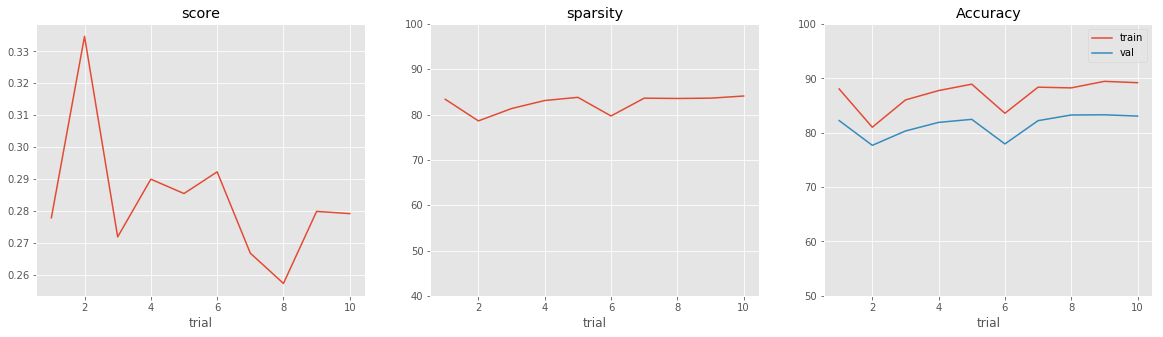

In [70]:
drawTrainingProcess(df)

In [92]:
best = loadBestParams(outputDir)

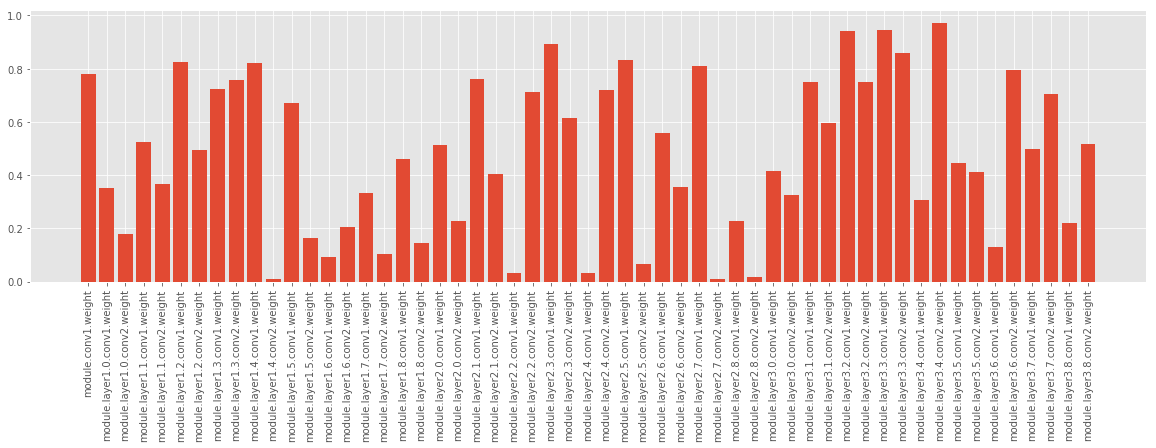

In [93]:
drawBestHyperParams(best)

## Algorithm: Random Search

### [rand] No Constraint

In [32]:
def main():
    space = get_space()
    best = fmin(objective, space, algo=hyperopt.rand.suggest, max_evals=args.rounds)
    return best

In [33]:
outputDir = os.path.join('./logs', datetime.datetime.now().strftime("%Y%m%d_%H%M%S"))
os.mkdir(outputDir)

f = open(os.path.join(outputDir, 'trials.log'), 'w')       
f.write("trial,score,train acc,val acc,sparsity\n")
count = 0
best = main()
f.close()

with open(os.path.join(outputDir, 'best.json'), 'w') as f:       
    f.write(json.dumps(best))

 1 trials: score: 0.2980	train acc:87.4022	val acc:81.0600	test acc:82.9300	sparsity:45.6980
 2 trials: score: 0.2624	train acc:86.3222	val acc:81.5000	test acc:82.4600	sparsity:61.2892
 3 trials: score: 0.2618	train acc:88.6511	val acc:83.0600	test acc:83.8100	sparsity:53.8223
 4 trials: score: 0.2642	train acc:87.9000	val acc:81.7800	test acc:82.9200	sparsity:59.0169
 5 trials: score: 0.2873	train acc:87.9267	val acc:81.6200	test acc:83.7100	sparsity:48.2540
 6 trials: score: 0.2895	train acc:86.8978	val acc:81.0600	test acc:82.5900	sparsity:49.9257
 7 trials: score: 0.2744	train acc:88.3978	val acc:82.4800	test acc:83.7200	sparsity:50.3904
 8 trials: score: 0.2725	train acc:87.2822	val acc:82.7800	test acc:83.2500	sparsity:49.8620
 9 trials: score: 0.2644	train acc:87.7444	val acc:82.4200	test acc:83.4000	sparsity:55.7215
10 trials: score: 0.2633	train acc:86.8822	val acc:82.2400	test acc:82.8400	sparsity:57.1688


In [64]:
outputDir = './logs/20181108_145445'

In [65]:
df = loadTrialLogs(outputDir)

,trial,score,train acc,val acc,sparsity
0,1,0.30,87.40,81.06,82.93
1,2,0.26,86.32,81.50,82.46
2,3,0.26,88.65,83.06,83.81
3,4,0.26,87.90,81.78,82.92
4,5,0.29,87.93,81.62,83.71
5,6,0.29,86.90,81.06,82.59
6,7,0.27,88.40,82.48,83.72
7,8,0.27,87.28,82.78,83.25
8,9,0.26,87.74,82.42,83.40
9,10,0.26,86.88,82.24,82.84


(50, 100)

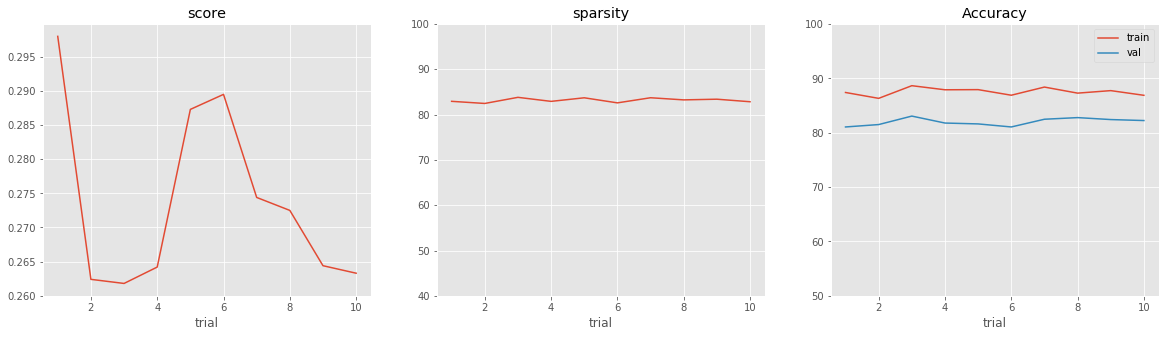

In [66]:
drawTrainingProcess(df)

In [89]:
best = loadBestParams(outputDir)

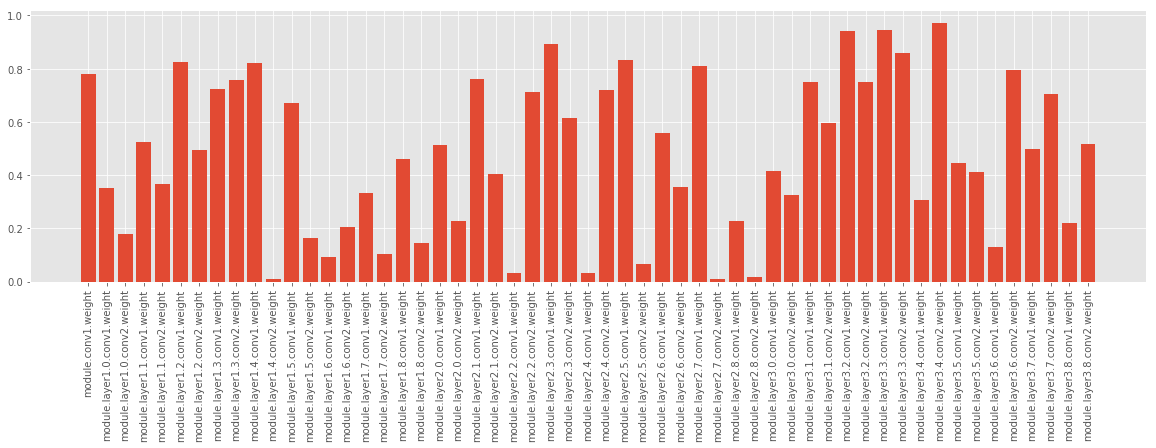

In [90]:
drawBestHyperParams(best)